In [1]:
# std
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import re
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# img viz
import matplotlib.pyplot as plt
import seaborn as sns

# img proc
import cv2
from skimage import color, io

# ml
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# tensorflow
import tensorflow as tf

# torch
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Datasets

In [3]:
class PlantDataset(Dataset):
  """Load images as needed. Directory must be placed as: datadir/split/category/*.png"""
  def __init__(self,
                datadir='/content/drive/MyDrive/Tomato Leaf Disease Classification/final_dataset',
                split='train',
                fmt='np'):
      # store image list from disk
      self.im_paths = sorted(glob.glob(os.path.join(datadir, split, '**/*.png')))
      # store the labels and create lookup for easy retrieval
      self.lbl_list = list(map(lambda lbl: lbl.split(os.path.sep)[-2].lower(), self.im_paths))
      self.lbl_cat_lkp = {e: i for i, e in enumerate(sorted(list(set(self.lbl_list))))}
      self.cat_lbl_lkp = {i: e for e, i in self.lbl_cat_lkp.items()}
      self.cat = np.array([self.lbl_cat_lkp[e] for e in self.lbl_list])
      self.fmt=fmt
      self.split=split

  def get_impath(self, idx): return self.im_paths[idx]

  def __getitem__(self, idx):
      """Return processed image from file list"""
      if self.fmt=='torch':
          im_path = self.im_paths[idx]
          tim = read_image(im_path, ImageReadMode.RGB)
          return tim/255, self.cat[idx]
      elif self.fmt=='np':
          im_path = self.im_paths[idx]
          npim = plt.imread(im_path)[..., :3] # remove alpha channel
          return npim, self.cat[idx]

  def __len__(self): return len(self.im_paths)

train_dset = PlantDataset()
print(f'>> Images on {train_dset.split}: {len(train_dset):,}')
print(pd.Series(train_dset.lbl_list).value_counts())

val_dset = PlantDataset(split='validation')
print(f'\n>> Images on {val_dset.split}: {len(val_dset):,}')
print(pd.Series(val_dset.lbl_list).value_counts())

test_dset = PlantDataset(split='test')
print(f'\n>> Images on {test_dset.split}: {len(test_dset):,}')
print(pd.Series(test_dset.lbl_list).value_counts())

print(f'\n>> Total images: {len(test_dset) + len(val_dset) + len(train_dset):,}')

>> Images on train: 14,523
tomato_yellow_leaf_curl_virus           4285
bacterial_spot                          1701
late_blight                             1527
septoria_leaf_spot                      1416
spider_mites_two-spotted_spider_mite    1340
healthy                                 1272
target_spot                             1123
early_blight                             800
leaf_mold                                761
tomato_mosaic_virus                      298
dtype: int64

>> Images on validation: 1,812
tomato_yellow_leaf_curl_virus           535
bacterial_spot                          212
late_blight                             190
septoria_leaf_spot                      177
spider_mites_two-spotted_spider_mite    167
healthy                                 159
target_spot                             140
early_blight                            100
leaf_mold                                95
tomato_mosaic_virus                      37
dtype: int64

>> Images on test: 1,824

In [4]:
tf_ds = tf.data.Dataset.list_files('/content/drive/MyDrive/Tomato Leaf Disease Classification/final_dataset/test/**/*png', shuffle=False)

# Features

## Canny Histogram

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.color import rgb2gray

(-0.5, 255.5, 255.5, -0.5)

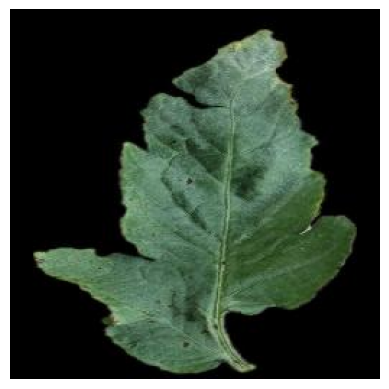

In [6]:
index = np.where(train_dset.cat==0)[0][0]
img = train_dset[index][0]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(img)
ax.axis('off')

(-0.5, 255.5, 255.5, -0.5)

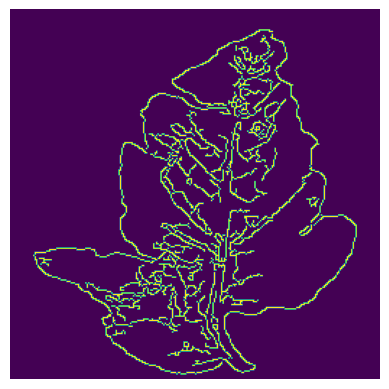

In [7]:
img = (img * 255).astype(np.uint8)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)


edges = cv2.Canny(blurred, 10, 130)
_, thresholded = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(thresholded)
ax.axis('off')

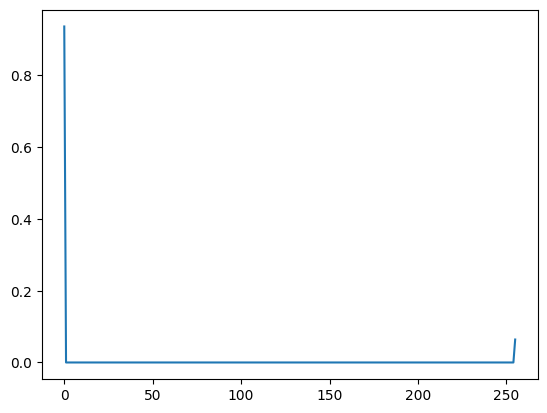

In [8]:
histogram = cv2.calcHist([thresholded], [0], None, [256], [0, 256])
normalized_histogram = histogram.flatten() / sum(histogram.flatten())

plt.plot(normalized_histogram)

In [9]:
canny_hist_feats = np.zeros(shape = (2,1))
canny_hist_feats[0] = normalized_histogram[0]
canny_hist_feats[1] = normalized_histogram[255]

print(canny_hist_feats)

[[0.93603516]
 [0.06396484]]


In [10]:
def get_canny_hist(img):
    img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 10, 130)
    _, thresholded = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)
    histogram = cv2.calcHist([thresholded], [0], None, [256], [0, 256])
    normalized_histogram = histogram.flatten() / sum(histogram.flatten())

    return normalized_histogram

In [11]:
def get_canny_features(dataset, **daisy_kwargs):
    """Calculate the Canny Features"""

    canny_feats = []
    count = 0
    try:
      for img, _ in dataset:
        img_canny_hist = get_canny_hist(img)
        img_canny_feats = np.zeros(shape = (2,1))
        img_canny_feats[0] = img_canny_hist[0]
        img_canny_feats[1] = img_canny_hist[255]

        canny_feats.append(img_canny_feats)
        count += 1
        if count % 500 == 0:
          print(f'Files processed: {count}')

      output = np.array(canny_feats)
      output = output.reshape(output.shape[0], 2)

      return output

    except Exception as e:
      print(str(e))

In [12]:
start_time = time.time()
train_canny_features = get_canny_features(train_dset)
print(f'Took {time.time() - start_time}s to gather Canny features for train dataset')
print(train_canny_features.shape)
pd.DataFrame(train_canny_features).to_csv('/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_canny.csv', index=False)

start_time = time.time()
val_canny_features = get_canny_features(val_dset)
print(f'Took {time.time() - start_time}s to gather Canny features for val dataset')
print(val_canny_features.shape)
pd.DataFrame(val_canny_features).to_csv('/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_canny.csv', index=False)

start_time = time.time()
test_canny_features = get_canny_features(test_dset)
print(f'Took {time.time() - start_time}s to gather Canny features for test dataset')
print(test_canny_features.shape)
pd.DataFrame(test_canny_features).to_csv('/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_canny.csv', index=False)

Files processed: 500
Files processed: 1000


KeyboardInterrupt: ignored

## Blob Detection Histogram

In [13]:
from skimage import exposure
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh

(-0.5, 255.5, 255.5, -0.5)

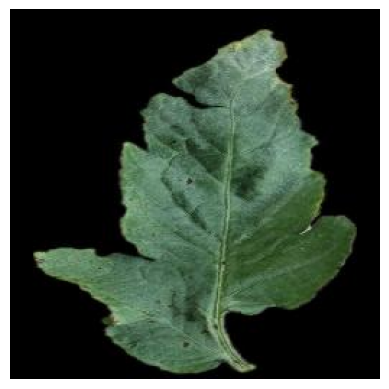

In [29]:
index = np.where(train_dset.cat==0)[0][0]
img = train_dset[index][0]

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(img)
ax.axis('off')

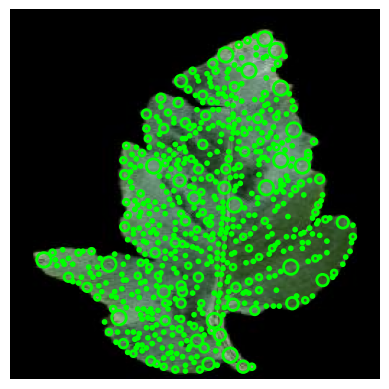

In [30]:
img = (img * 255).astype(np.uint8)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

blobs = blob_log(gray, min_sigma=1, max_sigma=5, num_sigma=5, threshold=.025)

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(img)
ax.axis('off')

for blob in blobs:
    y, x, sigma = blob
    c = plt.Circle((x, y), sigma, color='lime', linewidth=2, fill=False)
    ax.add_patch(c)

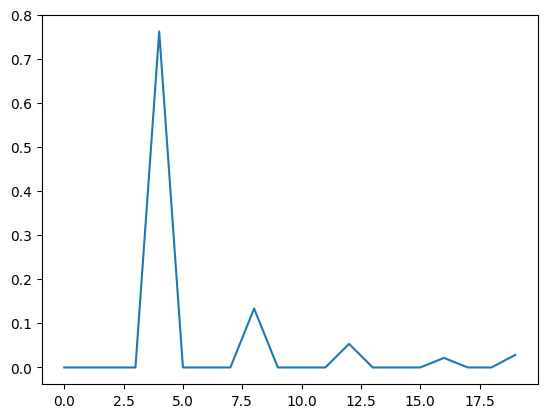

In [38]:
blob_radius = [blob[2] for blob in blobs]
hist, bin_edges = np.histogram(blob_radius, bins=20, range=(0, max(blob_radius)))
normalized_histogram = hist / np.sum(hist)

plt.plot(normalized_histogram)

In [39]:
print(normalized_histogram)

[0.         0.         0.         0.         0.76254181 0.
 0.         0.         0.13377926 0.         0.         0.
 0.05351171 0.         0.         0.         0.02173913 0.
 0.         0.02842809]


In [40]:
def get_blob_hist(img):
    img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blobs = blob_log(gray, min_sigma=1, max_sigma=5, num_sigma=5, threshold=.025)
    blob_radius = [blob[2] for blob in blobs]
    hist, bin_edges = np.histogram(blob_radius, bins=20, range=(0, max(blob_radius)))
    normalized_histogram = hist / np.sum(hist)

    return normalized_histogram

In [41]:
def get_blob_features(dataset, **daisy_kwargs):
    """Calculate the Blob Features"""

    blob_feats = []
    count = 0
    try:
      for img, _ in dataset:
        img_blob_feats = get_blob_hist(img)
        blob_feats.append(img_blob_feats)
        count += 1
        if count % 500 == 0:
          print(f'Files processed: {count}')

      output = np.array(blob_feats)
      output = output.reshape(output.shape[0], 20)

      return output

    except Exception as e:
      print(str(e))

In [42]:
start_time = time.time()
train_blob_features = get_blob_features(train_dset)
print(f'Took {time.time() - start_time}s to gather Blob features for train dataset')
print(train_blob_features.shape)
pd.DataFrame(train_blob_features).to_csv('/content/drive/MyDrive/Tomato Leaf Disease Classification/features/train_blob.csv', index=False)

start_time = time.time()
val_blob_features = get_blob_features(val_dset)
print(f'Took {time.time() - start_time}s to gather Blob features for val dataset')
print(val_blob_features.shape)
pd.DataFrame(val_blob_features).to_csv('/content/drive/MyDrive/Tomato Leaf Disease Classification/features/val_blob.csv', index=False)

start_time = time.time()
test_blob_features = get_blob_features(test_dset)
print(f'Took {time.time() - start_time}s to gather Blob features for test dataset')
print(test_blob_features.shape)
pd.DataFrame(test_blob_features).to_csv('/content/drive/MyDrive/Tomato Leaf Disease Classification/features/test_blob.csv', index=False)

Files processed: 500
Files processed: 1000
Files processed: 1500
Files processed: 2000
Files processed: 2500
Files processed: 3000
Files processed: 3500
Files processed: 4000
Files processed: 4500
Files processed: 5000
Files processed: 5500
Files processed: 6000
Files processed: 6500
Files processed: 7000
Files processed: 7500
Files processed: 8000
Files processed: 8500
Files processed: 9000
Files processed: 9500
Files processed: 10000
Files processed: 10500
Files processed: 11000
Files processed: 11500
Files processed: 12000
Files processed: 12500
Files processed: 13000
Files processed: 13500
Files processed: 14000
Files processed: 14500
Took 5906.754414796829s to gather Blob features for train dataset
(14523, 20)
Files processed: 500
Files processed: 1000
Files processed: 1500
Took 776.3772127628326s to gather Blob features for val dataset
(1812, 20)
Files processed: 500
Files processed: 1000
Files processed: 1500
Took 799.5594046115875s to gather Blob features for test dataset
(1824